## Introduction to Large-Scale Network Analysis with Pyspark and Graphframe

## Background

This tutorial provides an introduction on how to conduct large-scale network analysis using Spark and graphframe. This tutorial will focus on basic features of Pyspark SQL that can be applied toward computation on large graph. Features of graphframe (a package in Spark that focuses on graph-related computation) will also be introduced. 

Before we proceed to the rest of this tutorial, I will provide some background of Spark. Spark is a computing framework developed by Apache Foundation in 2013 to overcome some shortcoming of Apache Hadoop MapReduce. General pipeline of MapReduce is as follow: apply function to some data on disk and assign a key (map), group data by batch and distribute batches of data to computing nodes (shuffle), aggregate the batch of data to a single result (reduce) and store on Disk. This process is slow as it relies on disk operation (streaming batch of data to individual computing node and reading into disk for further computing job) and somewhat cumbersome (for each computing job, a mapper and reducer has to be provided). Spark is faster than the Hadoop MapReduce for most of the computing tasks as it is optimized for such computation. Also, since the introduction of Data Frame and Spark SQL since Spark 1.6, such cumbersomeness will also be alleviated as some of the computing jobs can be expressed in SQL expressions. For example, a simple word count program can be done by just `wordDF.groupby('word').count()` given all words are parsed and stored in a data frame called `wordDF` with column `word`. 

## Setting up Environment and IO
After a rough introduction of Spark, we will begin the tutorial by setting up Spark Environment. Spark has api for Scala, Python, and R. For this tutorial, I will use Spark's api for Python, which is Pyspark. Installing Pyspark is easy as it is available in PyPi. To install, just type `pip install pyspark` in your shell, as it will automatically install the dependency and add pyspark in the `PATH`. For installation of other api, I suggest reading https://spark.apache.org/downloads.html for downloads and installation. 

To test whether Spark is properly installed, type `pyspark` in your shell. If you see the following message pop up in your shell:
``` shell
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.0
      /_/

Using Python version 3.7.0 (default, Jun 28 2018 13:15:42)
SparkSession available as 'spark'
```
Then you have pyspark correctly installed and configured.

After installing pyspark, we will first run Spark in local mode. To use Spark, we will need an entry point. Such entry point will be a `SparkSession` object (given that we deal mostly with DataFrames). Note that in the above shell message, a default `SparkSession` object is created as `spark`. Now, we will show how to create one `SparkSession` with desired configuration. 

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
# Create configuration for Spark Session
conf = SparkConf() \
    .setAll([('spark.executor.memory', '16g'),
             ('spark.executor.cores', '8'),
             ('spark.cores.max', '8'),
             ('spark.driver.memory','16g'),
             ('spark.sql.execution.arrow.enabled', True)])

# Create a spark session
demo = SparkSession.builder.config(conf=conf).getOrCreate()

In the code snippet above, note that we add in the key-value pair `('spark.sql.execution.arrow.enabled', True)` into our Spark config. Apache Arrow is a standardized in-memory data storage format. A noticeable feature of Arrow is that it is language-independent. As the data are stored in memory in Arrow format, there is no conversion overhead for data transferring between python and Spark. This configuration is also essential to our next steps, as it enables the use of pandas udf (pandas user defined function). 

After installing Pyspark, let's try creating some DataFrames in Spark. Pyspark SQL accepts multiple formats of input, such as csv, json, pandas, parquet, etc. We will try reading data from parquet format. Parquet is a columnar, binary storage format. It is the on-disk storage format for the Arrow format we mentioned above. We can convert a csv/txt file to a parquet file by first converting it to a pandas dataframe and then convert it to parquet. The following code snippet describe the steps of converting a text file to a parquet file:

In [ ]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Read from csv to create a pandas data frame
edges_pd = pd.read_csv('data/edges.csv', columns = ['src', 'dst'])
edges_pd.to_parquet('data/edges.parquet', index=False)

Now, we should have a file named `edges.parquet` with column `src` and `dst` in a directory `data` (Create one beforehand if you don't have one already). Now, let's try reading this parquet file into our current Spark Session as a data.frame and see what it looks like.

In [2]:
edges_df = demo.read.parquet('data/edges.parquet')
edges_df.show(10)

+----+---+
| src|dst|
+----+---+
| -35| 27|
| -28|263|
|-165|100|
| -26|263|
| -65|134|
| -26|134|
| -65| 90|
|-144| 75|
|-732|242|
|-249|475|
+----+---+
only showing top 10 rows



## Pyspark SQL and Pandas UDF
After we load our `edges` dataframe into our Spark session, we shall now exlpore more features of the pyspark sql. Since the first data frame `edges` is in the form of an adjacency list, we can do some very basic graphic EDA using SQL. Now suppose that all positive number in the `edges` data frame is a GitHub user's ID, while every negative number represents the ID of a GitHub repository. Then each row in our `edges` table represents an edge from `src` to `dst` in this simple graph. Next, we want to know what are the indegrees and outdegrees of repositories on GitHub. It turns out that it is quite easy to do so with Spark SQL. All we need is three table operations: `filter()`, `groupby()`, and `count()`. Let's take the calculation of indegree of repositories as an example:

In [3]:
import pyspark.sql.functions as F
repo_indegree = edges_df.filter('dst < 0') \
    .groupby('dst') \
    .count() \
    .withColumnRenamed('dst', 'id') \
    .withColumnRenamed('count', 'inDegree').cache()
repo_indegree.show(10)

+------+--------+
|    id|inDegree|
+------+--------+
|  -882|       1|
| -1299|       1|
| -3150|       1|
| -4657|       1|
| -8001|       9|
| -8659|       5|
|-10751|       1|
|-10798|       1|
|-12237|      20|
|-16813|       8|
+------+--------+
only showing top 10 rows



Now, we will break down the above code snippet. First, we filter out the entries where the destination positive (only keeping negative number which represents the repositories). Next, we group by the destination nodes and aggregate each grouped data by counting the number of rows in each group. Using this `repo_indegree ` table, we can check the degree distribtion of GitHub's repo's contribution. Using the function `approxQuantile` provided in pyspark.sql, we can calculate the approximate empirical cdf of the indegree for the repositories on GitHub. 

/home/rgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


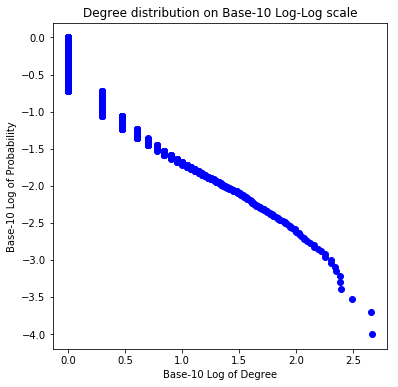

In [7]:
import matplotlib.pyplot as plt
import numpy as np


samp_probs = np.linspace(1e-4, 1, int(1e4)).tolist()
degree_quantile = repo_indegree.stat \
            .approxQuantile(col='inDegree',
                            probabilities=samp_probs,
                            relativeError=1e-4)
plt.figure(figsize=(6, 6))
plt.plot(np.log10(degree_quantile),
         np.log10([1 - i for i in samp_probs]),
                'bo')
plt.xlabel('Base-10 Log of Degree')
plt.ylabel('Base-10 Log of Probability')
plt.title('Degree distribution on Base-10 Log-Log scale')
plt.show()

Although pyspark.sql.functions provide a wide range of function library, in some cases we may find that none of the function provided fits our need. For example, in our following graphframe example, we want to have an aggregate function that returns most frequent item within a list, and if there are ties, choose uniformly random on the set of most frequent items. The existed spark sql function library doesn't seem to have such function. Now, we will need the help of Pandas UDF (User defined function). A User Defined Function (udf) in pyspark.sql is a function operation on the columns of data frame converted from a Python function that the user define. A pandas udf is a special type of udf, as it takes in `pandas.DataFrame` or `pandas.Series` and it allows the action of aggregate on columns, which is not achievable by the function `udf` provided in `pyspark.sql.functions`. It is also claimed to be optimized against the usual `udf`. There are three types of pandas udf, `SCALAR`, `GROUPED_MAP`, `GROUPED_AGG`. `SCALAR` pandas udf is a similar type of udf as `udf` provided in `pyspark.sql.functions`, as it takes in a column and return another column of the same length. `GROUPED_MAP`  is a type of udf that goes in hand with `groupby` operation, as it applies (map) a function on every observation within grouped data. `GROUPED_AGG` is an aggregate operation (reduce) within grouped data. This is the type of pandas udf that I will focus on here, as we need a function that reduces a list of items to one single value by returning the most frequent item. (_For a thorough tutorial on these three types of functions, I suggest reading this tutorial at https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html._) Now, let's look at the code snippet of our pandas UDF.

In [4]:
import numpy as np
from collections import Counter
from pyspark.sql.functions import pandas_udf, PandasUDFType
import pyspark.sql.functions as F


@pandas_udf("int", PandasUDFType.GROUPED_AGG)
def maxLabel_udf(label_list):
    # Filter out the Nones in the list
    label_list = list(filter(None, label_list))
    # Count the number of occurences for each item in list
    LabelCounts = Counter(label_list)
    # Retrieve the most frequent items in this list
    mostCommonLabels = [i[0] for i in LabelCounts.items()
                        if i[1] == max(LabelCounts.values())]
    # If there are multiple most frequent items, randomly draw one
    # and return
    return int(np.random.choice(mostCommonLabels))

# Create a toy data frame for testing purpose
udf_test = demo.createDataFrame([(1,), (2,), (3,), (2,), (2,)], ['Numbers',])
udf_test.show()

# Apply the pandas udf to the above data frame
udf_test.groupby() \
    .agg(maxLabel_udf(F.col('Numbers')) \
    . alias('Most Frequent item')).show()

# The udf returns 2 as the most frequent item, which is the
# correct answer

+-------+
|Numbers|
+-------+
|      1|
|      2|
|      3|
|      2|
|      2|
+-------+

+------------------+
|Most Frequent item|
+------------------+
|                 2|
+------------------+



In the code snippet above, we first use a decorator `@pandas_udf("int", PandasUDFType.GROUPED_AGG)` to define this udf to be an grouped aggregate function and the return type of this udf to be integer. In the next line, we just defined an ordinary python function that returns the most frequent label. Next, we just need to apply the function over the `Numbers` column. It seems like our pandas_udf returns the correct value. 

## Graphframe
After a brief introduction to the Pyspark SQL and pandas_udf, we will move our focus to graphframes and some of its basic functionality. In Spark's native library, there is a component named GraphX, which specializes for graph processing. In essential, GraphX represents a graph strcutre in the form of GraphRDD, which is a wrapper on top of VertexRDD and EdgeRDD (As every graph can be represented by a set of certices and a set of edges, and these two sets are stored in the form of RDD in Spark). The package includes algorithms such as BFS, DFS, pageRank, Label Propagation. It also provides an API for Pregel. However, GraphX doesn't have a python API. Thus, python user can not use the functionality included in GraphX for graph processing. 

Fortunately, there is another option for Python users which is called graphframes. It builds upon a similar idea as GraphX. Instead of using RDD to store the vertices and edges, graphframes uses dataframe as the form of storing the vertices and edges. graphframes comes with almost the same package of built-in algorithms as GraphX (in fact, these functions are directly translated from GraphX as RDD can be converted into DataFrames). Most importantly, it comes with a Python API so that Python process can get access to Java objects through Py4j. 

Remember that we have loaded an data frame called `edges_df`, which contains all the information between GitHub's users and repos. Now, we will load a data frame that represents all the nodes in our GitHub network called `vertices_df`. Then, we will create a graphframe object in Spark.

In [5]:
from graphframes import GraphFrame

# Read the vertices data frame
vertices_df = demo.read.parquet('data/vertices.parquet')
# Create a graphframe object
graphframe_demo = GraphFrame(vertices_df, edges_df)
# Only keep the edges where the destination is a repo
# and show the inDegrees of the filtered graph
graphframe_demo.filterEdges('dst < 0') \
    .inDegrees.show(10)

+------+--------+
|    id|inDegree|
+------+--------+
|  -882|       1|
| -1299|       1|
| -3150|       1|
| -4657|       1|
| -8001|       9|
| -8659|       5|
|-10751|       1|
|-10798|       1|
|-12237|      20|
|-16813|       8|
+------+--------+
only showing top 10 rows



In the code snippet above, we read in the vertices list from a parquet file to create a data frame called `vertices_df`. Using the `vertices_df` and `edges_df`, we created a graphframe object called `graphframe_demo`. The graphframe object has built-in functionalities considered useful. Getting back to the example where we calculate the in degrees of GitHub's repository. A `graphframe` object already has attributes `inDegrees` stored when the object is being constructed. Now, we will just need to use the function `filterEdges` to obtain the subgraph that only contains edges from users to repositories in our GitHub use-repo example and access the `inDegrees` of the subgraph. We can see that it produce the same result as in previous example.

graphframes also comes with common graph algorithms. Suppose we are interested in the influential (popular) GitHub repositories, we can use the included `pageRank` function.

In [6]:
pageRank_demo = graphframe_demo.pageRank(maxIter=10).vertices.cache()
top_10_repo = pageRank_demo \
        .filter('id < 0') \
        .orderBy(pageRank_demo.pagerank.desc()) \
        .take(10)

In [8]:
# Get the names of the repositories by IDs
from github import Github
from configparser import ConfigParser
import pandas as pd

parser = ConfigParser()
parser.read('github.auth')
user_1 = parser.sections()[3]
params = parser.items(user_1)
auth = {}
for param in params:
    auth[param[0]] = param[1]
g = Github(**auth)

repo_names = []
for repo in top_10_repo:
    repo_names.append(g.get_repo(-repo[0]).full_name)

top_10_repo = pd.concat([pd.DataFrame(top_10_repo, columns = ['Id', 'Page Rank']),
                         pd.DataFrame(repo_names, columns = ['Repo name',])],
                         axis = 1)
top_10_repo

,Id,Page Rank,Repo name
0,-10594164,346.344554,prism-break/prism-break
1,-17839626,275.924734,HGustavs/LenaSYS
2,-19726406,261.824003,strategist922/datasciencecoursera
3,-14681712,253.918046,jacano1969/MVC_framework
4,-20329618,244.805479,skillcrush/skillcrush-104
5,-18491419,240.140818,UIKit0/roslyn
6,-19369035,231.188696,TEAMMATES/teammates
7,-1175581,207.059437,citation-style-language/styles
8,-18524934,206.130144,Roll20/roll20-character-sheets
9,-10614101,204.298904,TheOdinProject/curriculum


## Message Passing

Now we have built a graphframe object in Spark and being able to conduct some network analysis with functionalities included in graphframe. Suppose we want to develop our own graph algorithms, what tools can graphframe and spark offer us? It turns out that graphframes' message passing API `aggregateMessages` and its related utility function library `AggregateMessages` are very powerful tools. Message passing builds upon the idea of 'thinking like a node'. Graph algorithms can then be transformed into 
    1. Nodes exchanging information through the links between each other.
    2. Aggregate information received at every node.
    3. Repeat the above steps until some stopping condition
    
Next, we will look at one example of how message passing is deployed. Suppose we want to write our own label propagation algorithm that is designed for bipartite network, especially for our GitHub network, how should we do that in Spark? Before diving into the code, I will briefly describe what is Label Propagation algorithm. It is intended for community detection in complex networks. The idea of the algorithm is simple: 
    Initially every node get its own label
    for each iteration, do:
        1. Every node send its labels to other nodes.
        2. Each node pick the most frequent label from its labels; 
        If there are ties, choose one label uniformly at random.

It is an efficient algorithm as for each node only needs to pick the most frequent label. And it is embarrassingly parallel. Based on the above algorithm, we now want to make some modification to better fit our GitHub network. Instead of assigning labels to every user and repo, we now want to assign every user a distinct label. And users send the labels to the repos that they have contributed. After repos received labels from the users, repos will then send the labels to its contributors and users that have forked from the repo. This alternating updating schema repeat until the desired number of iteration is completed. 

Time to look at some code:

In [ ]:
from graphframes.lib import AggregateMessages as AM

# Determine node type of the vertices; 1 is user, 2 is repo
nodeTypeUDF = F.udf(lambda i: 1 if i > 0 else 2, types.IntegerType())
vertices_df = vertices_df.withColumn('nodeType', nodeTypeUDF(F.col('id')))

# Assign initial label to the users
initLabelUDF = F.udf(lambda i, j: i if j == 1 else None,
                     types.IntegerType())
v = graphframe_demo.vertices.withColumn('label',
        initLabelUDF(F.col('id'), F.col('nodeType')))

# Add edges for every node that goes to itself
E_self = demo.createDataFrame(v.select(F.col('id')).rdd)
E = graphframe_demo.edges.union(
        E_self.withColumn('dst', F.col('id'))
        .withColumnRenamed('id', 'src'))

# Create a new graphframe object with labels attached
LPAbgf = GraphFrame(v, E)

In the code cell above, what we did is just assign new label to every user and create a new graphframe object with each node has its label attached. Next, we will define the message that each node send to its neighbors and how the messages are aggregated at each node.

In [ ]:
# Set Number of iteration
numIter = 5
for iter_ in range(numIter):
    for nodeType in [1, 2]:
        # For user and repo nodes, send their labels to
        # their destination nodes in alternating order
        msgForDst = F.when(AM.src['nodeType'] == nodeType,
                           AM.src['label'])
        # If it's repo's turn to send label to their destinations,
        # also send repo's label's to its contributors
        if nodeType == 2:
            msgForSrc = F.when(AM.src['nodeType'] == 1, AM.dst['label'])
        else:
            msgForSrc = None

        # Aggregate messages received from each node
        aggregates = LPAbgf.aggregateMessages(
                aggCol = maxLabel_udf(AM.msg).alias("aggMess"),
                sendToDst = msgForDst,
                sendToSrc = msgForSrc)
        v = LPAbgf.vertices

        # Update Labels for each node; If there is message for
        # the node, update the node's Label
        newLabelCol = F.when(aggregates["aggMess"].isNotNull(),
                             aggregates["aggMess"]
                            ).otherwise(v['label'])
        # Outer join aggregates and vertices
        vNew = (v
            .join(aggregates, on=(v['id'] == aggregates['id']),
                how='left_outer').drop(aggregates['id'])
            # Compute new column
            .withColumn('newLabel', newLabelCol)
            # Drop messages
            .drop('aggMess')
            # Drop old labels
            .drop('label')
            .withColumnRenamed('newLabel', 'label')
        )
        # Get the cached data frame of new vertices
        # to avoid memory over flow issue
        cachedvNew = AM.getCachedDataFrame(vNew)
        LPAbgf = GraphFrame(cachedvNew, E)


# get rid of the self oriented edges in the data frame
LPAbgf = GraphFrame(LPAbgf.vertices,
                    graphframe_demo.edges)

This is a long cell of code... But bear with me. Let's read this code line by line..
From the first two line, we can see that for each iteration, we alternatively set user and repo to send their labels to their destination nodes. We use `msgForDst` to define the content of the message that the destination nodes receive. We also specify that when it's repos' turn to send label, also send their label to its contributors. Here, `AM.src` and `AM.dst` are references for columns of source and destination. We can think of them as edge-triplets: source node and destination node are tables that contains information about the nodes in the `vertices_df` table, while the edges in `edges_df` table builds the tunnel for them to exchange information. 

After we define the content of message, we will define how to aggregate the message at each node. The instance method `aggregateMessages` provided in graphframe gives us an entry point. In the function, we set the argument `aggCol` equal to an sparl sql column expression or a pyspark function/udf that takes in `AM.msg`, which is a column that specifies the content of the messages received by each node. Here, we use the pandas udf that we write in previous section to aggregate the labels received by choosing the most common one. `aggregateMessages` will then return a data frame `aggregates` composed of columns `id` and `aggMess`. 

Next, we will do left outer join the vertices table `v` with our aggregated message dataframe `aggregates` and update the labels. Finally, using the new vertices table `vnew` and edges `E`, we will create a new graphframe object to either use in the next iteration or to return the final labelling result.

## Runtime efficiency
Speaking of making the code run faster. The above code takes about 22 minutes to run one iteration for Spark running in local mode (16gbs of RAM, 8 logical CPU) for a network with about 6 million nodes and 14 million edges. The Label propagation algorithm provided by graphframe (which is translated GraphX's implementation using RDD and Pregel) use around the same time for one iteration of label updating.